1. Always try to reduce the effort needed for the model training. There should never be a hockey stick like curve in training.
2. 

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()
len(words)

32033

In [3]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {ch: i for i, ch in stoi.items()}
vocab_size = len(itos)

In [5]:
block_size = 3
X, Y = [], []
for w in words:
#     print(w)
    context = [0]*block_size
    w = w + '.'
    for ch in w:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(f"For context: {''.join([itos[c] for c in context])} the output is: {itos[ix]}")
        context = context[1:] + [ix]
#     print("***"*5)
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
#build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:

        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


learn more here: https://blog.ezyang.com/2019/05/pytorch-internals/

we need to concatenate the emb to convert it to a 2-D tensor
this is not scalable approach as there can be change in block_size
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape

to solve this we can use torch.unbind()

torch.cat(torch.unbind(emb, 1), 1)

a better approach is to use torch.view()

In [65]:
# embeddings for our characters, cramming them into a 2 dimensional space
n_embed = 10
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed), generator=g)

# 6 because of the 3*2
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)*(5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
# we want the inital weights to be as closer to 0 as possible so scaling it down
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0 # dont need to add bias as we want values closer to 0
parameters = [C, W1, b1, W2, b2]
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


tensor(0.0041) tensor(0.9875)
tensor(0.0111) tensor(3.0569)


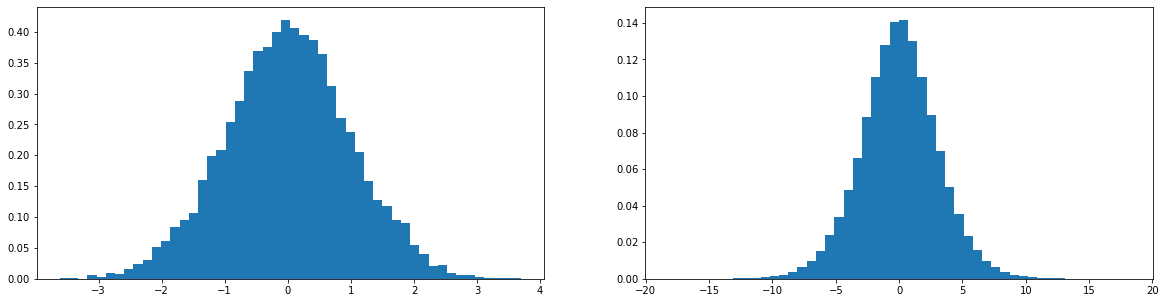

In [59]:
# we can see here that std of y increased
# in NN we generally want to preserve the std from input to activation
# mathematically, weight should be divided by square root of input nodes
# for tanh the gain defined in the paper: https://arxiv.org/pdf/1502.01852.pdf is 5/3
# the value which should be multiplied to W1 is (5/3)/(30**0.5) = 0.3
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [66]:
max_steps = 200000
batch_size = 32
lossi = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
#     # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [61]:
# at the begining we expect the model to return any character with a probability of 1/27.
# so the negative loss likelikhood should give a value of 3.29
# This is the error from which our model should begin with
-torch.tensor(1/27.0).log()

tensor(3.2958)

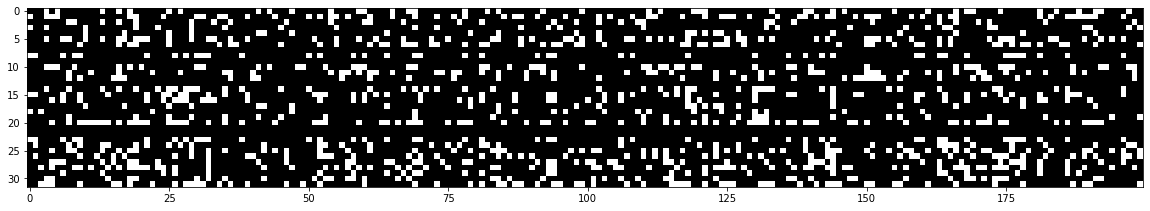

In [46]:
# if there were any column with all white or all blacks it means that
# no gradient will ever flow through there and network will not be a good learner
# black here is false values and white is true
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

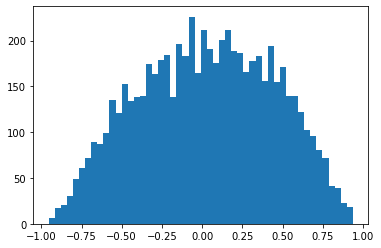

In [40]:
# let us now see the problem with the squashing function tanh
# this is really bad because in backpropagation, the differentiation
# of tanh will 0 and hence no gradient values will be propagated properly
# to solve this issue we can squash the inital W1 and b1 to be closer to 0 by multiplying by small values
# this is just after initialisation
plt.hist(h.view(-1).tolist(), 50);

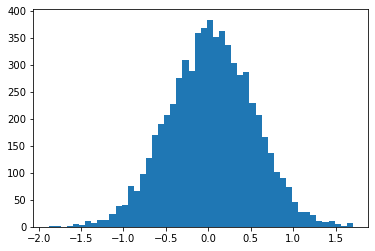

In [41]:
# is we see the values of h before the application of tanh
# we can see that the values were spread very broadly
# this is just after initialisation
plt.hist(hpreact.view(-1).tolist(), 50);

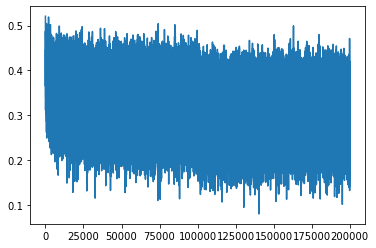

In [62]:
plt.plot(lossi)

In [68]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [69]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1
#     hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0668387413024902
val 2.1050267219543457


In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mruagimbayleegh.
nyhah.
mareth.
sreka.
leigh.
ched.
eli.
hemi.
rea.
eme.
shagraah.
kayydosharace.
shughrgahi.
aedr.
kaireteyson.
beus.
kuya.
gregruyah.
azela.
kay.


Without any changes
Training - 2.13, validation - 2.17

After removing the hockey stick curve, brining the inital loss to as close as possible
Training - 2.06, validation - 2.13

After fixing the squashing of tanh values at initialisation
Training - 2.03, validation - 2.10

After making sure the std is not too widespread
Training - 2.03, validation - 2.10

After inital batch normalization changes
Training - 2.06, validation - 2.10